In [2]:
import json
import numpy as np
import os
from scipy import spatial
# from open3d import *
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from natsort import natsorted

In [3]:
# 以下注释使用 fitten code 生成

# 真值标签准备

# 数据集路径
dataset_path = "custom_data/"
# 初始化文件列表
all_files = []
# 获取数据集路径下的所有文件和文件夹
all_sets = os.listdir(dataset_path)

# 遍历所有文件夹
for folder in all_sets:
    # 排除名为 "train_test_split" 的文件夹
    if folder != "train_test_split":
        # 设置激光雷达、校准、雷达和地面实况的路径
        lidar_path = dataset_path + folder + "/lidar_os1/"
        calibration_path = dataset_path + folder + "/calibration/"
        radar_path = dataset_path + folder + "/radar_hires1/"
        radar_path_label = dataset_path + folder + "/label/"
        radar_path_gt = dataset_path + folder + "/radar_gt/"
        
        # 确保地面实况路径存在，如果不存在则创建
        if not os.path.exists(radar_path_gt):
            os.mkdir(radar_path_gt)
        
        # 获取激光雷达路径下的所有 .txt 文件，并按自然顺序排序
        fileList = natsorted([f for f in os.listdir(lidar_path) if f.endswith('.txt')])
        
        # 遍历每个激光雷达文件
        for file in fileList:
            # 构建文件路径
            file_path = lidar_path + file
            # 读取激光雷达数据，跳过第一行，只读取前四列
            data = np.loadtxt(file_path, delimiter=" ", skiprows=1, usecols=[0,1,2,3])
            # 过滤数据，保留 x 在 0 到 70 之间，y 和 z 小于 70 的点
            sdata = data[(data[:,0]>0) & (data[:,0]<70) & (data[:,1]<70) & (data[:,2]<70)]
            # 将第四列（假设为标签列）设置为 1
            sdata[:, 3] =  1
            # 转换为 numpy 数组
            lidar_data = np.array(sdata)
        
            # 读取校准矩阵
            path = calibration_path + file[:-4] + ".json"
            with open(path, 'r') as json_file:
                data = json.load(json_file)
            sensors = data['sensors']
            T_to_ref_COS = None
            # 查找激光雷达的校准矩阵
            for sensor in sensors:
                if sensor['sensor_uid'] == "lidar_vlp16":
                    T_to_ref_COS = sensor["calib_data"]["T_to_ref_COS"]
                    break
            
            # 校准激光雷达数据
            T_to_ref_COS = np.array(T_to_ref_COS)
            # 将激光雷达数据投影到参考坐标系中
            projected_lidar = np.dot(lidar_data, T_to_ref_COS)
            projected_lidar = projected_lidar[:,0:3]
            
            # 生成地面实况
            # 构建 KDTree 以快速查找
            tree = spatial.cKDTree(projected_lidar)
            # 构建雷达文件路径
            radar_file_path = radar_path + file
            # 读取雷达数据，跳过前两行，只读取前五列
            radar = np.loadtxt(radar_file_path, delimiter=" ", skiprows=2, usecols=[0,1,2,3,4])
            count = 0
            # 初始化雷达数据数组，增加一列用于存储标签
            radar_data = np.zeros((radar.shape[0],radar.shape[1]+1))
            radar_data[:,:-1] = radar
            # 遍历每个雷达点
            for i in radar_data:
                # 查找雷达点是否在投影后的激光雷达点附近
                if(len(tree.query_ball_point(i[0:3], 1)) > 0):
                    # 如果找到，设置标签为 1
                    i[5] = int(1)
                    count += 1

            # 保存地面实况数据
            np.savetxt(radar_path_gt + file, radar_data, header="X Y Z V_r Mag Label", delimiter=" ", comments='')
            # 打印文件名、真点数和总点数
            print("\nFilename:", file, "\nTrue point count:", count, "\nTotal point count:", len(radar_data))



Filename: 000000.txt 
True point count: 279 
Total point count: 831

Filename: 000001.txt 
True point count: 294 
Total point count: 855

Filename: 000002.txt 
True point count: 339 
Total point count: 890

Filename: 000003.txt 
True point count: 494 
Total point count: 1213

Filename: 000004.txt 
True point count: 533 
Total point count: 1199

Filename: 000005.txt 
True point count: 559 
Total point count: 1256

Filename: 000006.txt 
True point count: 560 
Total point count: 1257

Filename: 000007.txt 
True point count: 599 
Total point count: 1230

Filename: 000008.txt 
True point count: 446 
Total point count: 1366

Filename: 000009.txt 
True point count: 641 
Total point count: 1479

Filename: 000010.txt 
True point count: 650 
Total point count: 1549

Filename: 000011.txt 
True point count: 586 
Total point count: 1570

Filename: 000012.txt 
True point count: 632 
Total point count: 1700

Filename: 000013.txt 
True point count: 856 
Total point count: 2382

Filename: 000014.txt 


In [4]:
# 示例文件列表
dataset_path = "custom_data/"
all_files = []

for folder in os.listdir(dataset_path):
    if folder != "train_test_split":
        data_path = os.path.join(dataset_path, folder, "radar_gt")
        fileList = os.listdir(data_path)
        for file in fileList:
            file_path = os.path.join(folder, "radar_gt", file)
            all_files.append(file_path)

# 将文件列表转换为 NumPy 数组
all_files = np.array(all_files)

# 划分数据集
train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)
print("Number of training samples:", len(train_files))
print("Number of testing samples:", len(test_files))
# 保存文件列表
with open(os.path.join('custom_data', 'train_test_split', 'shuffled_train_file_list.json'), 'w') as json_file:
    json.dump(train_files.tolist(), json_file)
with open(os.path.join('custom_data', 'train_test_split', 'shuffled_test_file_list.json'), 'w') as json_file:
    json.dump(test_files.tolist(), json_file)


Number of training samples: 873
Number of testing samples: 219


In [5]:
# 数据增强函数
def dataAugmentation(data):
    """
    对输入数据进行数据增强，包括旋转和平移变换。

    参数:
    data (numpy.ndarray): 输入的三维点云数据，形状为 (N, 3)，其中 N 是点的数量。

    返回:
    numpy.ndarray: 增强后的三维点云数据，形状为 (N, 3)。
    """
    # 随机生成旋转角度，范围为 -5 到 5 度
    angle = random.randint(-5, 5)
    
    # 随机生成平移量，范围为 -1 到 1
    dx = random.uniform(-1, 1)
    dy = random.uniform(-1, 1)
    dz = random.uniform(-1, 1)
    
    # 计算旋转角度的余弦和正弦值
    cos = np.cos(np.deg2rad(angle))
    sin = np.sin(np.deg2rad(angle))
    
    # 构建旋转矩阵 R
    R = np.array([
        [cos, sin, 0], 
        [-sin, cos, 0], 
        [0, 0, 1]
    ])
    
    # 对数据进行旋转
    data = np.dot(data, R)
    
    # 对数据进行平移
    data[:, 0] += dx
    data[:, 1] += dy
    data[:, 2] += dz
    
    # 返回增强后的数据
    return data


In [6]:
# 数据增强

print("here")  # 打印提示信息

# 数据集路径
dataset_path = "custom_data/"

# 获取数据集路径下的所有文件和文件夹
all_sets = os.listdir(dataset_path)

# 遍历所有文件夹
for folder in all_sets:
    # 排除名为 "train_test_split" 的文件夹
    if folder != "train_test_split":
        # 设置雷达地面实况数据的路径
        data_path = dataset_path + folder + "/radar_gt/"

        # 获取雷达地面实况路径下的所有 .txt 文件，并按自然顺序排序
        fileList = natsorted([f for f in os.listdir(lidar_path) if f.endswith('.txt')])
        
        # 遍历每个文件
        for file in fileList:
            # 构建文件路径
            file_path = data_path + file
            
            # 读取雷达数据，跳过第一行，只读取前三列（X, Y, Z）
            radar_data = np.loadtxt(file_path, delimiter=" ", skiprows=1, usecols=[0,1,2])
            
            # 对雷达数据进行数据增强
            radar_data_aug = np.concatenate((dataAugmentation(radar_data), 
                                             np.loadtxt(file_path, delimiter=" ", skiprows=1, usecols=[3,4,5])), 
                                            axis=1)
            
            # 保存增强后的数据到新文件，文件名为原文件名加上 "_aug"
            np.savetxt(file_path[:-4] + '_aug.txt', radar_data_aug, 
                       header="X Y Z V_r Mag Label", delimiter=" ", comments='')


here


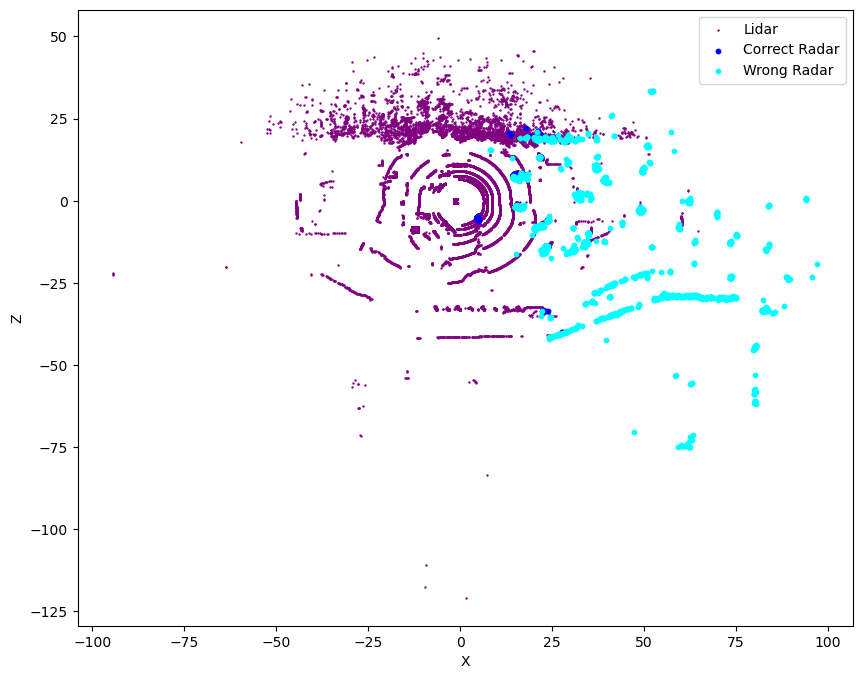

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取激光雷达数据
lidar_file_path = "custom_data/sample_set/lidar_os1/000100.txt"
lidar_df = pd.read_csv(lidar_file_path, sep=' ', header=0)
lidar = lidar_df.loc[:, 'X':'Z'].values

# 读取雷达数据
radar_file_path = "custom_data/sample_set/radar_gt/000100.txt"
radar_df = pd.read_csv(radar_file_path, sep=" ", header=0)

# 提取正确和错误的雷达数据
radar_corr = radar_df.loc[(radar_df['Label'] == 1), 'X':'Z'].values
radar_wrong = radar_df.loc[(radar_df['Label'] == 0), 'X':'Z'].values

# 创建前视图图形
fig, ax = plt.subplots(figsize=(10, 8))

# 绘制激光雷达数据的前视图
ax.scatter(lidar[:, 0], lidar[:, 1], c='purple', label='Lidar', s=0.5)

# 绘制正确的雷达数据的前视图
ax.scatter(radar_corr[:, 0], radar_corr[:, 1], c='blue', label='Correct Radar', s=10)

# 绘制错误的雷达数据的前视图
ax.scatter(radar_wrong[:, 0], radar_wrong[:, 1], c='cyan', label='Wrong Radar', s=10)

# 设置图形属性
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.legend()

# 保存图片
plt.savefig("img_2d.png")

# 显示图形
plt.show()

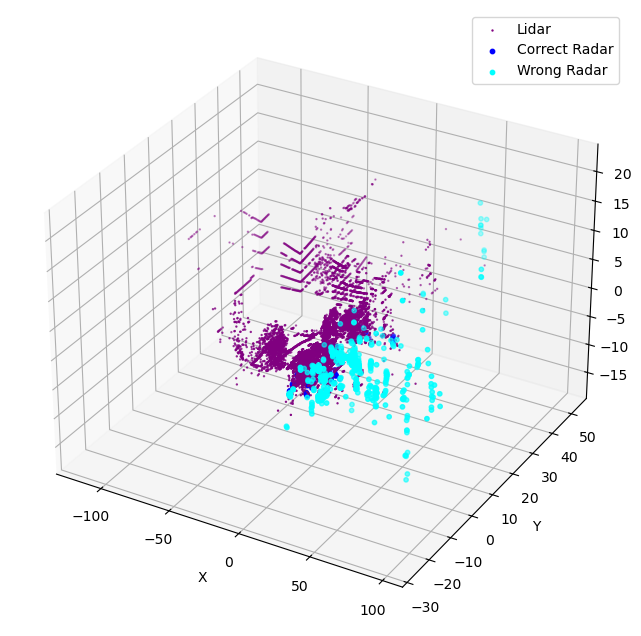

In [12]:
# transformation matrix converts from sensorA->sensorB to sensorB->sensorA

# 读取激光雷达数据
lidar_file_path = "custom_data/sample_set/lidar_os1/000000.txt"
lidar_df = pd.read_csv(lidar_file_path, sep=' ', header=0)
lidar = lidar_df.loc[:, 'X':'Z'].values

# 读取雷达数据
radar_file_path = "custom_data/sample_set/radar_gt/000000.txt"
radar_df = pd.read_csv(radar_file_path, sep=" ", header=0)

# 提取正确和错误的雷达数据
radar_corr = radar_df.loc[(radar_df['Label'] == 1), 'X':'Z'].values
radar_wrong = radar_df.loc[(radar_df['Label'] == 0), 'X':'Z'].values

# 创建3D图形
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制激光雷达数据
ax.scatter(lidar[:, 0], lidar[:, 1], lidar[:, 2], c='purple', label='Lidar', s=0.5)

# 绘制正确的雷达数据
ax.scatter(radar_corr[:, 0], radar_corr[:, 1], radar_corr[:, 2], c='blue', label='Correct Radar', s=10)

# 绘制错误的雷达数据
ax.scatter(radar_wrong[:, 0], radar_wrong[:, 1], radar_wrong[:, 2], c='cyan', label='Wrong Radar', s=10)

# 设置图形属性
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# 调整视角为俯瞰图
# ax.view_init(elev=90, azim=-90)

# 保存图片
plt.savefig("img_3d.png")

# 显示图形
plt.show()


